In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax
from jax import random, numpy as jnp
import flax
from flax import linen as nn

In [88]:
model = nn.Dense(features=1)

In [89]:
key, key_consume = random.split(random.key(100))
x = jnp.zeros((1,))
params = model.init(key_consume, x)
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (1,), 'kernel': (1, 1)}}

In [90]:
n_samples = 20
x_dim = 1
y_dim = 1

key, key_W, key_b = random.split(key, 3)

W = random.normal(key_W, (x_dim, y_dim))
b = random.normal(key_b, (y_dim,))
true_params = flax.core.freeze({ 'params': { 'kernel': W, 'bias': b } })

key, key_sample, key_noise = random.split(key, 3)
x_samples = random.uniform(key_sample, (n_samples, x_dim))
y_samples = jnp.dot(x_samples, W) + b + (0.10 * random.normal(key_noise, (n_samples, y_dim)))


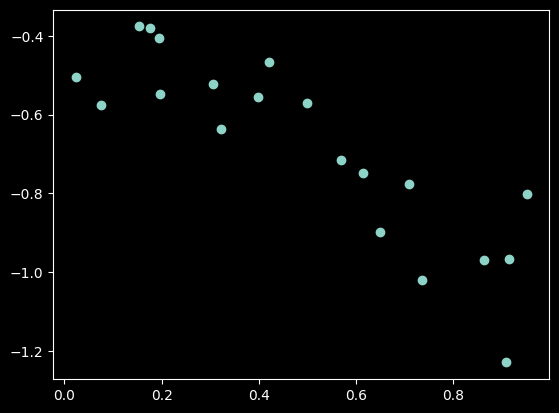

In [91]:
plt.style.use('dark_background')
plt.scatter(x_samples, y_samples)

In [92]:
@jax.jit
def mse(params, x_batched, y_batched):
    def squre_error(x, y):
        pred = model.apply(params, x)
        return jnp.inner(pred - y, pred - y) / 2.0
    return jnp.mean(jax.vmap(squre_error)(x_batched, y_batched), axis=0)

In [93]:
learning_rate = 0.3
print('Loss for "true" W,b: ', mse(true_params, x_samples, y_samples))
loss_grad_fn = jax.jit(jax.value_and_grad(mse))

@jax.jit
def update_params(params, learning_rate, grads):
    return jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

for i in range(1001):
    loss_val, grads = loss_grad_fn(params, x_samples, y_samples)
    params = update_params(params, learning_rate, grads)
    if i % 10 == 0:
        print(f'Loss at step {i}: {loss_val}')

Loss for "true" W,b:  0.007097948
Loss at step 0: 0.17722150683403015
Loss at step 10: 0.00821335893124342
Loss at step 20: 0.007779079955071211
Loss at step 30: 0.007501335348933935
Loss at step 40: 0.0073179020546376705
Loss at step 50: 0.007196756545454264
Loss at step 60: 0.007116748485714197
Loss at step 70: 0.0070639061741530895
Loss at step 80: 0.00702900905162096
Loss at step 90: 0.007005959749221802
Loss at step 100: 0.006990738213062286
Loss at step 110: 0.0069806850515306
Loss at step 120: 0.006974044721573591
Loss at step 130: 0.0069696614518761635
Loss at step 140: 0.006966763641685247
Loss at step 150: 0.006964852102100849
Loss at step 160: 0.006963589694350958
Loss at step 170: 0.006962754763662815
Loss at step 180: 0.006962203420698643
Loss at step 190: 0.00696184067055583
Loss at step 200: 0.006961600389331579
Loss at step 210: 0.00696144113317132
Loss at step 220: 0.006961335893720388
Loss at step 230: 0.006961266975849867
Loss at step 240: 0.006961220409721136
Loss a

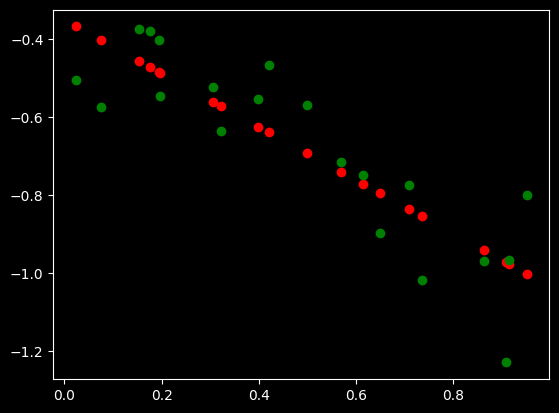

In [94]:
y_test = model.apply(params, x_samples)
plt.scatter(x_samples, y_test, color='red')
plt.scatter(x_samples, y_samples, color='green')
plt.show()